<a href="https://colab.research.google.com/github/Dazzyayan/mlds-research-project/blob/main/ts2vec_attempt_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# prompt: mount google drive mlds_research_project folder
from google.colab import drive
drive.mount('/content/drive')

# Navigate to the desired folder (replace 'mlds_research_project' with your actual folder name)
import os
os.chdir('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

import sys

# Add the specific directory to the Python path
sys.path.append('/content/drive/MyDrive/_mlds_research_project/')
sys.path.append('/content/drive/MyDrive/_mlds_research_project/ts2vec/')

from ts2vec import TS2Vec
import datautils
import torch
print(torch.cuda.is_available())

Mounted at /content/drive
True


In [55]:
# @title Train TS2Vec
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from ts2vec import TS2Vec
from scipy.signal import find_peaks, correlate
import torch
import torch.nn.functional as F

def train_ts2vec_model(train_data, input_dims=1, output_dims=64, device=0):
    """
    Trains a TS2Vec model on the provided training data.

    Args:
        train_data (np.ndarray): Training data (n_instances, n_timestamps, n_features).
        input_dims (int): Input dimensions for TS2Vec model.
        output_dims (int): Output dimensions for TS2Vec representations.
        device (int): Device to use for training (0 for GPU, -1 for CPU).

    Returns:
        TS2Vec: The trained TS2Vec model.
    """
    print("Training TS2Vec model...")
    model = TS2Vec(
        input_dims=input_dims,
        device=device,
        output_dims=output_dims
    )
    loss_log = model.fit(
        train_data,
        verbose=False
    )
    print("TS2Vec model training complete.")
    return model

  # Train the TS2Vec model
trained_model = train_ts2vec_model(
    train_data=train_data_gen,
    input_dims=train_data_gen.shape[-1], # Use the actual input dimensions from the data
    device=0 # Specify device if needed
)

Training TS2Vec model...
TS2Vec model training complete.


In [4]:
# @title Generate Simulated Data

# Assuming /content/drive/MyDrive/mlds_research_project is in your Python path
from sim_gen import milestone_2_sim
import numpy as np


# Initialize empty lists to store data and changepoints
synthetic_data = []
synthetic_cps = []

# Loop 100 times to generate data
for _ in range(1000):
    # Generate a single instance of data and its changepoints
    # data, cps, _ = milestone_2_sim.generate_changepoint_data(M=5)
    data, cps, _ = milestone_2_sim.generate_changepoint_ar_data(M=5)

    # Reshape the data if it's 1D to ensure a feature dimension
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    # Append the generated data and changepoints to the lists
    synthetic_data.append(data)
    synthetic_cps.append(cps)

# Note: The generated time series instances might have different lengths.
# Further processing will be needed to handle variable lengths,
# for example, by padding or truncation before using them in TS2Vec.
# For now, we just store them as a list of arrays.

# Determine the maximum length among the generated time series
max_len = max(data.shape[0] for data in synthetic_data)

# Pad the synthetic data instances to the maximum length
padded_synthetic_data = []
for data in synthetic_data:
    padding_length = max_len - data.shape[0]
    # Pad with zeros at the end along the time dimension (axis=0)
    padded_data = np.pad(data, ((0, padding_length), (0, 0)), mode='constant', constant_values=0)
    padded_synthetic_data.append(padded_data)

# Convert the list of padded arrays into a single NumPy array
train_data_gen = np.stack(padded_synthetic_data, axis=0)

# For simplicity in this analysis, we will use the same padded data for testing
test_data_gen = np.stack(padded_synthetic_data, axis=0)

# Create dummy labels for the 100 instances (e.g., all zeros)
# The actual labels are not directly used in the TS2Vec analysis for changepoint detection,
# but a label array is required by the analyze_ts2vec_with_peak_finding function signature.
train_labels_gen = np.zeros(len(synthetic_data))
test_labels_gen = np.zeros(len(synthetic_data))

# Prepare the ground truth changepoints in a format expected by the analysis function
# The analyze function expects a list of lists, where each inner list contains the changepoints for an instance.
ground_truth_cps_gen = synthetic_cps

print(f"Shape of generated and padded training data: {train_data_gen.shape}")
print(f"Shape of generated and padded testing data: {test_data_gen.shape}")
print(f"Number of ground truth changepoint lists: {len(ground_truth_cps_gen)}")

Shape of generated and padded training data: (1000, 899, 1)
Shape of generated and padded testing data: (1000, 899, 1)
Number of ground truth changepoint lists: 1000


In [5]:
def evaluate_changepoint_detection(ground_truth_cps, detected_cps, tolerance=5):
    """
    Evaluates changepoint detection performance for a single instance.

    Args:
        ground_truth_cps (list): List of ground truth changepoint timestamps.
        detected_cps (list): List of detected changepoint timestamps.
        tolerance (int): The tolerance window around ground truth changepoints
                         to consider a detected changepoint a True Positive.

    Returns:
        tuple: (tp, fp, fn, precision, recall, f1_score)
               tp (int): True Positives
               fp (int): False Positives
               fn (int): False Negatives
               precision (float): Precision score
               recall (float): Recall score
               f1_score (float): F1-score
    """
    tp = 0
    fp = 0
    fn = 0

    # Create a boolean array to track if a ground truth CP has been matched
    matched_gt = [False] * len(ground_truth_cps)

    # Count True Positives and False Positives
    for detected_cp in detected_cps:
        is_tp = False
        for i, gt_cp in enumerate(ground_truth_cps):
            if abs(detected_cp - gt_cp) <= tolerance and not matched_gt[i]:
                tp += 1
                matched_gt[i] = True
                is_tp = True
                break # Move to the next detected CP once a match is found
        if not is_tp:
            fp += 1

    # Count False Negatives (ground truth CPs that were not matched)
    fn = len(ground_truth_cps) - sum(matched_gt)

    # Calculate Precision, Recall, and F1-score
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0

    return tp, fp, fn, precision, recall, f1_score

In [57]:
# @title Componentised Changepoint
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from sklearn.metrics.pairwise import cosine_similarity
from scipy.signal import find_peaks, convolve


def generate_ts2vec_representations_component(model, data, sliding_length, sliding_padding):
    """
    Generates TS2Vec representations for the input data using the provided model.

    Args:
        model (TS2Vec): The trained TS2Vec model.
        data (np.ndarray): Input data (n_instances, n_timestamps, n_features).
        sliding_length (int): Sliding window length for encoding.
        sliding_padding (int): Sliding window padding for encoding.

    Returns:
        np.ndarray: TS2Vec representations (n_instances, n_timestamps, output_dims).
    """
    print("Generating sliding window representations...")
    representations = model.encode(
        data,
        causal=True,
        sliding_length=sliding_length,
        sliding_padding=sliding_padding
    )
    print(f'Shape of representations: {representations.shape}')
    print("Representation generation complete.")
    return representations

# Function to calculate the L2 distance between two vectors
def calculate_l2_distance(vec1, vec2):
    """
    Calculates the L2 (Euclidean) distance between two vectors.

    Args:
        vec1 (np.ndarray): The first vector.
        vec2 (np.ndarray): The second vector.

    Returns:
        float: The L2 distance.
    """
    # Ensure both vectors have the same shape before calculating distance
    if vec1.shape != vec2.shape:
        # This should ideally not happen if pooling is done correctly,
        # but as a safeguard, handle mismatch (e.g., pad or resize if appropriate,
        # or raise an error if it indicates a fundamental issue).
        # Given the context, we expect flattened single vectors.
        # Let's print shapes for debugging if this occurs.
        print(f"Shape mismatch: vec1.shape={vec1.shape}, vec2.shape={vec2.shape}")
        # For now, raise the error to understand the cause.
        raise ValueError("Shape mismatch in vectors for L2 distance calculation.")

    return np.linalg.norm(vec1 - vec2)

def calculate_online_moving_average_component(signal, window):
    """
    Calculates online moving average for a signal.

    Args:
        signal (list): The signal values.
        window (int): The window size for the moving average.

    Returns:
        float: The latest moving average or np.nan if window size is not met.
    """
    if len(signal) >= window:
        return np.mean(signal[-window:])
    else:
        return np.nan

def calculate_online_std_dev_component(signal, window):
    """
    Calculates online standard deviation for a signal.

    Args:
        signal (list): The signal values.
        window (int): The window size for the standard deviation.

    Returns:
        float: The latest standard deviation or np.nan if window size is not met.
    """
    if len(signal) >= window:
        return np.std(signal[-window:])
    else:
        return np.nan

def detect_changepoint_stddev_threshold_component(latest_value, moving_average, std_dev, threshold_multiplier):
    """
    Detects a changepoint based on a standard deviation threshold.

    Args:
        latest_value (float): The latest value of the signal (e.g., L2 distance).
        moving_average (float): The moving average of the signal.
        std_dev (float): The standard deviation of the signal.
        threshold_multiplier (float): The multiplier for the standard deviation to set the threshold.

    Returns:
        bool: True if a changepoint is detected, False otherwise.
    """
    if np.isnan(latest_value) or np.isnan(moving_average) or np.isnan(std_dev):
        return False

    threshold = moving_average + threshold_multiplier * std_dev
    return latest_value > threshold

def reset_online_state_component():
    """
    Resets the online state variables after a changepoint detection.

    Returns:
        tuple: (empty_list,) for current segment signal.
    """
    return [],


def maxpool(poold):
  # Calculate p based on the input size
  p = int(np.log2(poold.shape[1] - 1)) if poold.shape[1] > 1 else 0
  output = F.max_pool1d(poold.transpose(1, 2),
              kernel_size = (1 << (p + 1)) + 1,
              stride = 1,
              padding = 1 << p
              ).transpose(1, 2)
  return output


def run_changepoint_analysis_componentized(model, test_data, test_labels, sliding_length=1, sliding_padding=6, num_instances_to_plot=10, moving_average_window=10, peak_height=None, peak_threshold=None, peak_distance=None, peak_prominence=None, peak_width=None, peak_wlen=None, peak_rel_height=None, ground_truth_cps=None, peak_on_difference=True, lookback_window=10, evaluation_tolerance=5, stddev_threshold_multiplier=2, local_window_size=6, num_latest_points_to_compare=2): # Added num_latest_points_to_compare
    """
    Analyzes TS2Vec representations for changepoint detection using a componentized approach,
    calculating L2 distance between max-pooled sliding window representations.

    Args:
        model (TS2Vec): The trained TS2Vec model.
        test_data (np.ndarray): Test data (n_instances, n_timestamps, n_features).
        test_labels (np.ndarray): Test labels.
        sliding_length (int): Sliding window length for encoding.
        sliding_padding (int or list): Sliding window padding for encoding. Can be a single value or a list of values.
        num_instances_to_plot (int): Number of test instances to plot.
        moving_average_window (int): Window size for moving average of cosine similarity (or filtered similarity).
        peak_height (float or array_like or None): Required height of peaks for offline plotting.
        peak_threshold (float or array_like or None): Required threshold of peaks for offline plotting.
        peak_distance (float or array_like or None): Required horizontal distance between neighboring peaks for offline plotting.
        peak_prominence (float or array_like or None): Required prominence of peaks for offline plotting.
        peak_width (float or array_like or None): Required width of peaks for offline plotting.
        peak_wlen (int or None): A window length in samples for offline plotting.
        peak_rel_height (float or None): The relative height for offline plotting.
        ground_truth_cps (list or None): Ground truth changepoint locations.
        peak_on_difference (bool): If True, perform offline peak detection on the absolute difference signal.
        lookback_window (int): The minimum number of previous timestamps required for the maxpooling window (segment since last CP).
        evaluation_tolerance (int): The tolerance window for matching detected changepoints to ground truth.
        stddev_threshold_multiplier (float): The multiplier for the standard deviation in online detection.
        local_window_size (int): The size of the local window for maxpooling with the latest timestamp.
        num_latest_points_to_compare (int): The number of latest timestamps to add/compare in each step.

    Returns:
        dict: Evaluation metrics by padding value.
    """
    # Ensure sliding_padding is a list
    if not isinstance(sliding_padding, list):
        sliding_padding_values = [sliding_padding]
    else:
        sliding_padding_values = sliding_padding

    evaluation_metrics_by_padding = {}

    # Validate ground_truth_cps if provided
    if ground_truth_cps is not None and len(ground_truth_cps) != len(test_data):
        print("Warning: Length of ground_truth_cps does not match the number of test instances.")
        ground_truth_cps = None

    # Limit the number of instances to process
    test_data_subset = test_data[:num_instances_to_plot]
    test_labels_subset = test_labels[:num_instances_to_plot]
    ground_truth_cps_subset = ground_truth_cps[:num_instances_to_plot] if ground_truth_cps is not None else None

    # Ensure num_latest_points_to_compare is at least 1
    if num_latest_points_to_compare < 1:
        print(f"Warning: num_latest_points_to_compare ({num_latest_points_to_compare}) must be at least 1. Adjusting to 1.")
        num_latest_points_to_compare = 1


    for current_padding in sliding_padding_values:
        print(f"\n--- Analyzing with sliding_padding = {current_padding} ---")

        # Component 1: Generate TS2Vec representations
        test_repr = generate_ts2vec_representations_component(
            model,
            test_data_subset,
            sliding_length,
            current_padding
        )

        n_instances, n_timestamps, output_dims = test_repr.shape

        print(f"Performing online analysis for {n_instances} instances with sliding_padding = {current_padding}...")

        instance_tp = []
        instance_fp = []
        instance_fn = []
        instance_precision = []
        instance_recall = []
        instance_f1 = []

        for i in range(n_instances):
            instance_repr = test_repr[i, :, :]
            original_data = test_data_subset[i, :, 0]

            # Initialize online processing state
            last_cp_index = 0
            detected_online_cps = []

            # Lists to store full history for plotting and offline analysis
            full_history_l2_distances = []
            full_history_moving_averages_online = [] # Only one MA now
            full_history_std_dev_online = [] # Std dev of L2 distance
            full_history_threshold_online = [] # Store the threshold for plotting


            # Lists to store segment data for online calculations
            current_segment_l2_distances = []


            # Component 2: Online Processing Loop - Stride by num_latest_points_to_compare
            # Start the loop at a point where the first window (size local_window_size) ending at t - num_latest_points_to_compare is valid
            start_time = local_window_size + num_latest_points_to_compare - 1
            for t in range(start_time, n_timestamps, num_latest_points_to_compare):
                # Get the representations for the sliding window excluding the latest points
                window_before_latest_start = max(0, t - local_window_size - num_latest_points_to_compare)
                window_before_latest_end = t - num_latest_points_to_compare
                window_before_latest_reprs = instance_repr[window_before_latest_start:window_before_latest_end, :]

                # Get the representations for the sliding window including the latest points
                window_with_latest_start = max(0, t - local_window_size)
                window_with_latest_end = t
                window_with_latest_reprs = instance_repr[window_with_latest_start:window_with_latest_end, :]


                # Check window sizes - ensure they have the desired size local_window_size
                if window_before_latest_reprs.shape[0] != local_window_size or window_with_latest_reprs.shape[0] != local_window_size:
                     # Append NaN if window sizes are not as expected
                     full_history_l2_distances.append(np.nan)
                     full_history_moving_averages_online.append(np.nan)
                     full_history_std_dev_online.append(np.nan)
                     full_history_threshold_online.append(np.nan)
                     current_segment_l2_distances.append(np.nan)
                     continue


                # Create window representation before latest by maxpooling
                poold_before = torch.from_numpy(window_before_latest_reprs).unsqueeze(0)
                # Use the provided maxpool function
                maxpooled_before_repr = maxpool(poold_before)
                # Ensure the max-pooled output is 2D (batch_size, output_dims) and convert to numpy
                maxpooled_before_repr_np = maxpooled_before_repr.squeeze(0).numpy()
                if maxpooled_before_repr_np.ndim == 1:
                     maxpooled_before_repr_np = maxpooled_before_repr_np.reshape(1, -1)


                # Create window representation with latest by maxpooling
                poold_with = torch.from_numpy(window_with_latest_reprs).unsqueeze(0)
                 # Use the provided maxpool function
                maxpooled_with_repr = maxpool(poold_with)
                # Ensure the max-pooled output is 2D (batch_size, output_dims) and convert to numpy
                maxpooled_with_repr_np = maxpooled_with_repr.squeeze(0).numpy()
                if maxpooled_with_repr_np.ndim == 1:
                    maxpooled_with_repr_np = maxpooled_with_repr_np.reshape(1, -1)


                # Component 3: Calculate L2 distance
                l2_distance = calculate_l2_distance(maxpooled_before_repr_np.flatten(), maxpooled_with_repr_np.flatten())
                full_history_l2_distances.append(l2_distance)
                current_segment_l2_distances.append(l2_distance)


                # Determine which signal to use for MA and difference calculation - Now always L2 distance
                signal_for_stats = current_segment_l2_distances
                valid_signal_for_stats = [val for val in signal_for_stats if not np.isnan(val)]

                # Component 5: Calculate online moving average and std dev of the L2 distance signal
                latest_ma = calculate_online_moving_average_component(
                    valid_signal_for_stats,
                    moving_average_window
                )
                full_history_moving_averages_online.append(latest_ma)

                latest_std_dev = calculate_online_std_dev_component(
                    valid_signal_for_stats,
                    moving_average_window
                )
                full_history_std_dev_online.append(latest_std_dev)


                # Calculate the threshold for plotting and detection (based on L2 distance stats)
                latest_value_for_detection = valid_signal_for_stats[-1] if len(valid_signal_for_stats) > 0 else np.nan
                # Use stddev_threshold_multiplier for the threshold calculation
                threshold_value = latest_ma + stddev_threshold_multiplier * latest_std_dev if not np.isnan(latest_ma) and not np.isnan(latest_std_dev) else np.nan
                full_history_threshold_online.append(threshold_value)


                # Component 7: Online changepoint detection
                changepoint_detected = detect_changepoint_stddev_threshold_component(
                    latest_value_for_detection,
                    latest_ma,
                    latest_std_dev,
                    stddev_threshold_multiplier
                )

                if changepoint_detected:
                    detected_online_cps.append(t) # Record the end timestamp of the window
                    print(f"Changepoint detected at timestamp {t} for instance {i+1}")
                    # Component 8: Reset online state
                    last_cp_index = t
                    current_segment_l2_distances = reset_online_state_component()[0]


            # Convert full history lists to numpy arrays for plotting
            full_history_l2_distances = np.array(full_history_l2_distances)
            full_history_moving_averages_online = np.array(full_history_moving_averages_online)
            full_history_std_dev_online = np.array(full_history_std_dev_online)
            full_history_threshold_online = np.array(full_history_threshold_online) # Convert threshold history to numpy array


            # Component 9: Offline Peak Finding (for plotting if needed) - Keep the logic but don't plot this signal
            signal_for_offline_peaks = None
            peak_x_offset = 0
            # Offline peak finding logic remains but will likely use L2 distance or a derivative if needed
            if len(full_history_l2_distances) > 0 and not np.all(np.isnan(full_history_l2_distances)):
                 signal_for_offline_peaks = full_history_l2_distances
                 peak_x_offset = np.where(~np.isnan(signal_for_offline_peaks))[0][0] if np.where(~np.isnan(signal_for_offline_peaks))[0].size > 0 else 0

            peaks = []
            if signal_for_offline_peaks is not None and len(signal_for_offline_peaks) > 0 and not np.all(np.isnan(signal_for_offline_peaks)):
                 try:
                     valid_signal_for_offline_peaks = signal_for_offline_peaks[~np.isnan(signal_for_offline_peaks)]
                     peaks, _ = find_peaks(
                         valid_signal_for_offline_peaks,
                         height=peak_height,
                         threshold=peak_threshold,
                         distance=peak_distance,
                         prominence=peak_prominence,
                         width=peak_width,
                         wlen=peak_wlen,
                         rel_height=peak_rel_height
                     )
                 except ValueError as e:
                     print(f"Warning: Could not perform offline peak finding for instance {i+1}: {e}")
                     peaks = []
            else:
                print(f"Warning: Signal for offline peak finding is empty or all NaN for instance {i+1}. Skipping peak detection.")


            # Component 10: Plotting results
            # Adjusted to 2 subplots
            fig, axes = plt.subplots(2, 1, figsize=(12, 9), sharex=True)

            # Plotting Original Time Series
            axes[0].plot(original_data)
            axes[0].set_title(f'Original Time Series for Instance {i+1} (Label: {test_labels_subset[i]}) - Padding: {current_padding}')
            axes[0].set_ylabel('Value')
            axes[0].grid(True)


            if ground_truth_cps_subset is not None and i < len(ground_truth_cps_subset):
                 for gt_cp in ground_truth_cps_subset[i]:
                      if gt_cp < n_timestamps:
                           axes[0].axvline(x=gt_cp, color='green', linestyle='-', lw=1.5, label='Ground Truth Changepoint' if gt_cp == ground_truth_cps_subset[i][0] else "")

            for online_cp in detected_online_cps:
                 if online_cp < n_timestamps:
                      axes[0].axvline(x=online_cp, color='orange', linestyle='--', lw=1.5, label='Detected Online CP' if online_cp == detected_online_cps[0] else "")

            handles, labels = axes[0].get_legend_handles_labels()
            unique_labels = {}
            for handle, label in zip(handles, labels):
                 unique_labels[label] = handle
            axes[0].legend(unique_labels.values(), unique_labels.keys())


            # Plotting L2 Distance and Online Detection (using full history)
            # Adjust timestamps for the signal plot based on the stride
            timestamps_for_signal_plot = np.arange(start_time, n_timestamps, num_latest_points_to_compare)

            if len(full_history_l2_distances) == len(timestamps_for_signal_plot): # L2 distance is calculated for each step
                 axes[1].plot(timestamps_for_signal_plot, full_history_l2_distances, label=f'L2 Distance (Window Before vs With Latest {num_latest_points_to_compare})') # Updated label


            # Plot moving average, std dev lines, and threshold on the L2 distance plot
            if len(full_history_moving_averages_online) == len(timestamps_for_signal_plot):
                 # Filter out NaN values for plotting
                 valid_indices_ma = ~np.isnan(full_history_moving_averages_online)
                 axes[1].plot(timestamps_for_signal_plot[valid_indices_ma], full_history_moving_averages_online[valid_indices_ma], label=f'Moving Average (window={moving_average_window})', color='red')

            if len(full_history_std_dev_online) == len(timestamps_for_signal_plot) and len(full_history_moving_averages_online) == len(timestamps_for_signal_plot):
                 # Filter out NaN values for plotting
                 valid_indices_std = ~np.isnan(full_history_std_dev_online) & ~np.isnan(full_history_moving_averages_online)
                 axes[1].plot(timestamps_for_signal_plot[valid_indices_std], full_history_moving_averages_online[valid_indices_std] + full_history_std_dev_online[valid_indices_std], color='gray', linestyle='--', lw=0.8, label='+1 Std Dev')
                 # Use stddev_threshold_multiplier for the Std Dev line label
                 axes[1].plot(timestamps_for_signal_plot[valid_indices_std], full_history_moving_averages_online[valid_indices_std] + stddev_threshold_multiplier * full_history_std_dev_online[valid_indices_std], color='darkgray', linestyle='--', lw=0.8, label=f'+{stddev_threshold_multiplier} Std Dev')


            # Plot the online detection threshold
            if len(full_history_threshold_online) == len(timestamps_for_signal_plot):
                 # Filter out NaN values for plotting
                 valid_indices_threshold = ~np.isnan(full_history_threshold_online)
                 axes[1].plot(timestamps_for_signal_plot[valid_indices_threshold], full_history_threshold_online[valid_indices_threshold], color='cyan', linestyle='-', lw=1.5, label=f'Online Threshold ({stddev_threshold_multiplier} Std Dev)')


            # Overlay detected online changepoints on the L2 distance plot
            if len(detected_online_cps) > 0:
                for online_cp in detected_online_cps:
                     if online_cp < n_timestamps: # online_cp is the original timestamp
                          axes[1].axvline(x=online_cp, color='orange', linestyle='--', lw=1, alpha=0.7)
                axes[1].plot([], [], color='orange', linestyle='--', lw=1, label=f'Detected Online CPs ({len(detected_online_cps)})')


            axes[1].set_title(f'L2 Distance and Online Detection - Padding: {current_padding}')
            axes[1].set_ylabel('L2 Distance')
            axes[1].set_xlabel('Timestamp')
            axes[1].legend()
            axes[1].grid(True)
            axes[1].set_xlim(0, n_timestamps - 1)


            plt.tight_layout()
            plt.show()


            # Component 11: Evaluate performance
            if ground_truth_cps_subset is not None:
                 gt_cps = ground_truth_cps_subset[i]
                 # Evaluate against online detected CPs
                 tp, fp, fn, precision, recall, f1 = evaluate_changepoint_detection(gt_cps, detected_online_cps, tolerance=evaluation_tolerance)
                 instance_tp.append(tp)
                 instance_fp.append(fp)
                 instance_fn.append(fn)
                 instance_precision.append(precision)
                 instance_recall.append(recall)
                 instance_f1.append(f1)
                 print(f"Instance {i+1} Evaluation (Padding: {current_padding}): TP={tp}, FP={fp}, FN={fn}, Precision={precision:.2f}, Recall={recall:.2f}, F1={f1:.2f}")
            else:
                 instance_tp.append(None)
                 instance_fp.append(None)
                 instance_fn.append(None)
                 instance_precision.append(None)
                 instance_recall.append(None)
                 instance_f1.append(None)
                 print(f"Instance {i+1} Evaluation (Padding: {current_padding}): Ground truth not available.")


        # Calculate and store average evaluation metrics for the current padding
        if ground_truth_cps_subset is not None and len(instance_tp) > 0 and all(item is not None for item in instance_tp):
             avg_tp = np.mean(instance_tp)
             avg_fp = np.mean(instance_fp)
             avg_fn = np.mean(instance_fn)
             avg_precision = np.mean([p for p in instance_precision if p is not None])
             avg_recall = np.mean([r for r in instance_recall if r is not None])
             avg_f1 = np.mean([f for f in instance_f1 if f is not None])

             evaluation_metrics_by_padding[current_padding] = {
                 'average_tp': avg_tp,
                 'average_fp': avg_fp,
                 'average_fn': avg_fn,
                 'average_precision': avg_precision,
                 'average_recall': avg_recall,
                 'average_f1_score': avg_f1
             }
             print(f"\nAverage Evaluation Metrics for Padding {current_padding}:")
             print(f"  Average TP: {avg_tp:.2f}")
             print(f"  Average FP: {avg_fp:.2f}")
             avg_fn = len(ground_truth_cps_subset) - avg_tp # Recalculate average FN based on total ground truth CPs
             print(f"  Average FN: {avg_fn:.2f}")
             print(f"  Average Precision: {avg_precision:.2f}")
             print(f"  Average Recall: {avg_recall:.2f}")
             print(f"  Average F1-score: {avg_f1:.2f}")
        else:
             evaluation_metrics_by_padding[current_padding] = {
                 'average_tp': None,
                 'average_fp': None,
                 'average_fn': None,
                 'average_precision': None,
                 'average_recall': None,
                 'average_f1_score': None
             }
             print(f"\nEvaluation metrics not calculated for Padding {current_padding} due to missing ground truth or no instances analyzed with valid metrics.")

        # Recalculate valid similarities and average after the loop for the histogram
        # Use the L2 distances for the histogram
        if len(full_history_l2_distances) > 0 and not np.all(np.isnan(full_history_l2_distances)):
             valid_l2_distances = full_history_l2_distances[~np.isnan(full_history_l2_distances)]
             if len(valid_l2_distances) > 0:
                  plt.figure(figsize=(8, 5))
                  plt.hist(valid_l2_distances, bins=20)
                  plt.title(f'Distribution of L2 Distance (Window Before vs With Latest {num_latest_points_to_compare}) Across Plotted Instances - Padding: {current_padding}')
                  plt.xlabel('L2 Distance')
                  plt.ylabel('Frequency')
                  plt.show()


    return evaluation_metrics_by_padding


--- Analyzing with sliding_padding = 6 ---
Generating sliding window representations...
Shape of representations: (5, 899, 64)
Representation generation complete.
Performing online analysis for 5 instances with sliding_padding = 6...
Changepoint detected at timestamp 83 for instance 1
Changepoint detected at timestamp 137 for instance 1
Changepoint detected at timestamp 269 for instance 1
Changepoint detected at timestamp 317 for instance 1
Changepoint detected at timestamp 365 for instance 1
Changepoint detected at timestamp 413 for instance 1
Changepoint detected at timestamp 515 for instance 1
Changepoint detected at timestamp 563 for instance 1
Changepoint detected at timestamp 665 for instance 1
Changepoint detected at timestamp 701 for instance 1
Changepoint detected at timestamp 773 for instance 1
Changepoint detected at timestamp 809 for instance 1


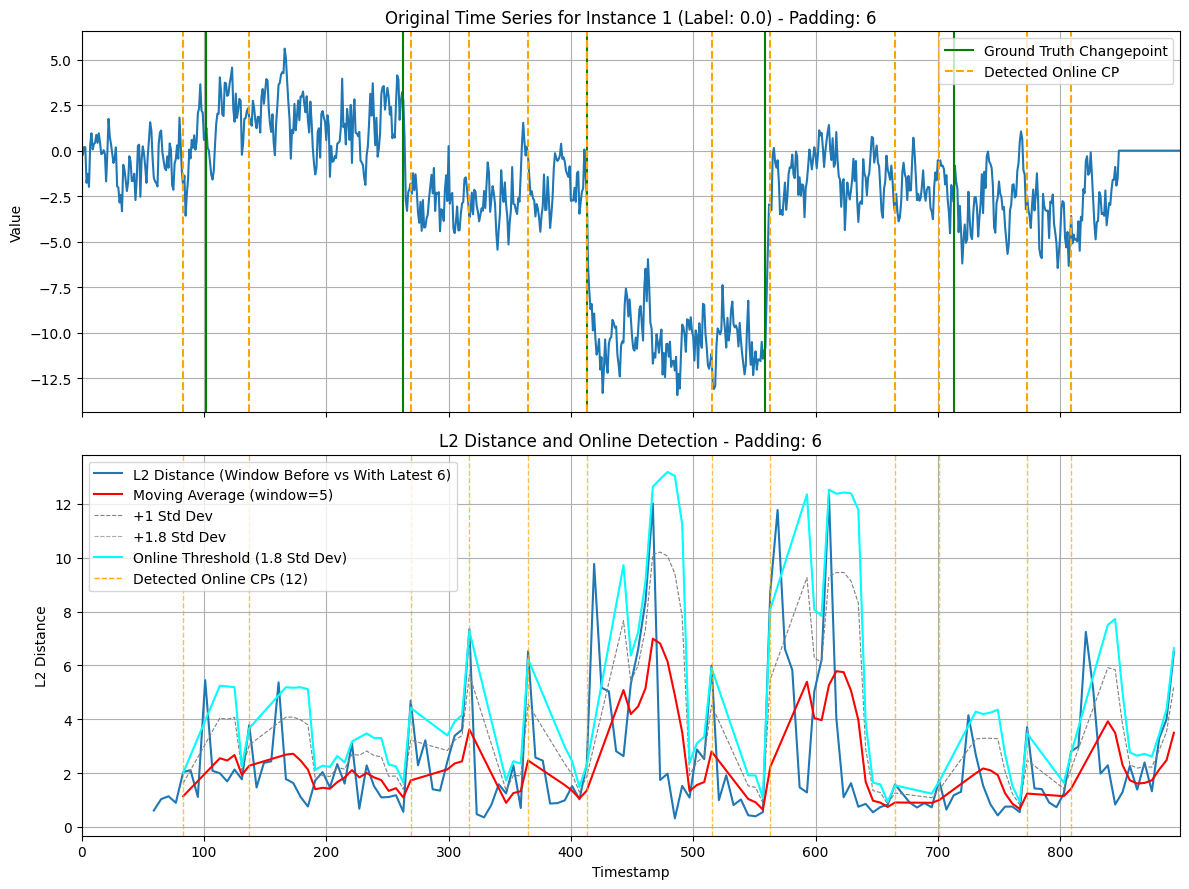

Instance 1 Evaluation (Padding: 6): TP=2, FP=10, FN=3, Precision=0.17, Recall=0.40, F1=0.24
Changepoint detected at timestamp 107 for instance 2
Changepoint detected at timestamp 215 for instance 2
Changepoint detected at timestamp 299 for instance 2
Changepoint detected at timestamp 401 for instance 2
Changepoint detected at timestamp 449 for instance 2
Changepoint detected at timestamp 503 for instance 2
Changepoint detected at timestamp 551 for instance 2
Changepoint detected at timestamp 743 for instance 2
Changepoint detected at timestamp 797 for instance 2
Changepoint detected at timestamp 887 for instance 2


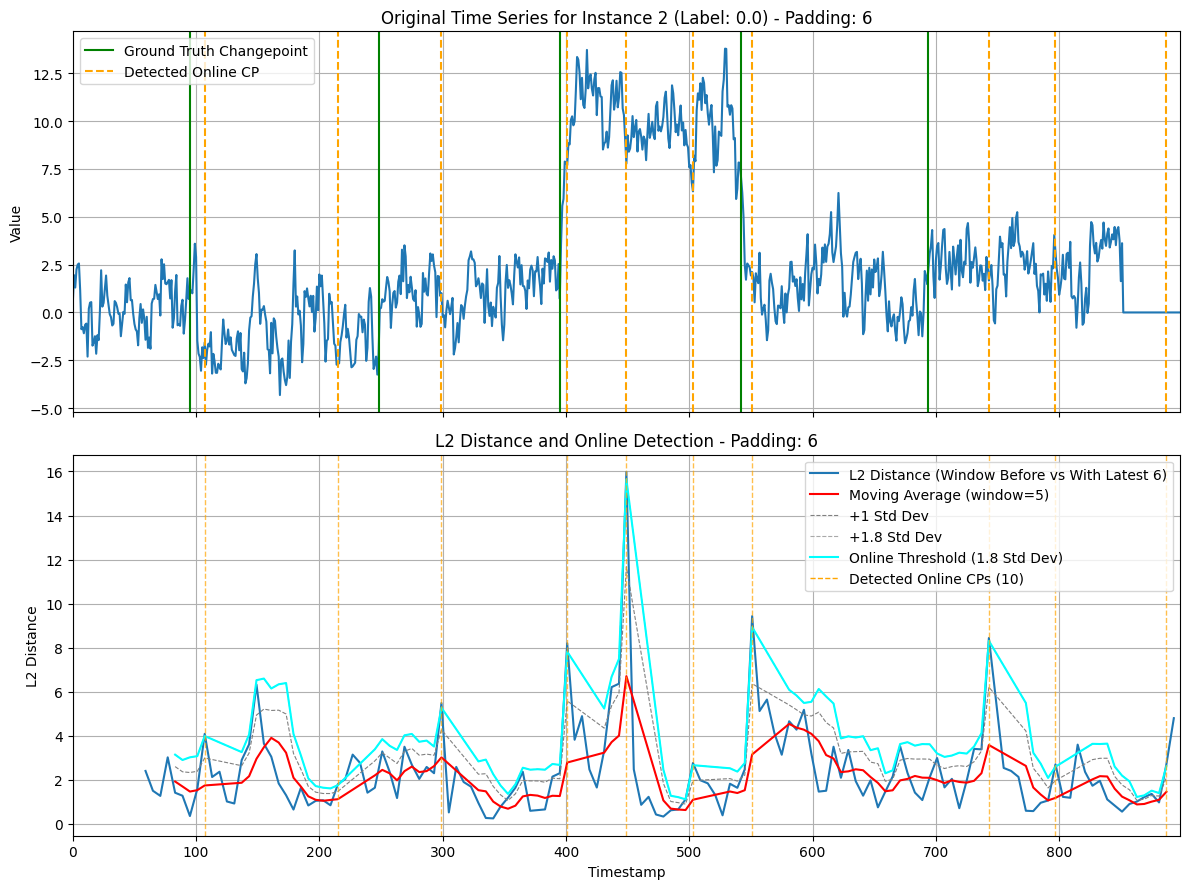

Instance 2 Evaluation (Padding: 6): TP=0, FP=10, FN=5, Precision=0.00, Recall=0.00, F1=0.00
Changepoint detected at timestamp 83 for instance 3
Changepoint detected at timestamp 137 for instance 3
Changepoint detected at timestamp 215 for instance 3
Changepoint detected at timestamp 371 for instance 3
Changepoint detected at timestamp 455 for instance 3
Changepoint detected at timestamp 557 for instance 3
Changepoint detected at timestamp 707 for instance 3
Changepoint detected at timestamp 755 for instance 3
Changepoint detected at timestamp 791 for instance 3
Changepoint detected at timestamp 845 for instance 3
Changepoint detected at timestamp 893 for instance 3


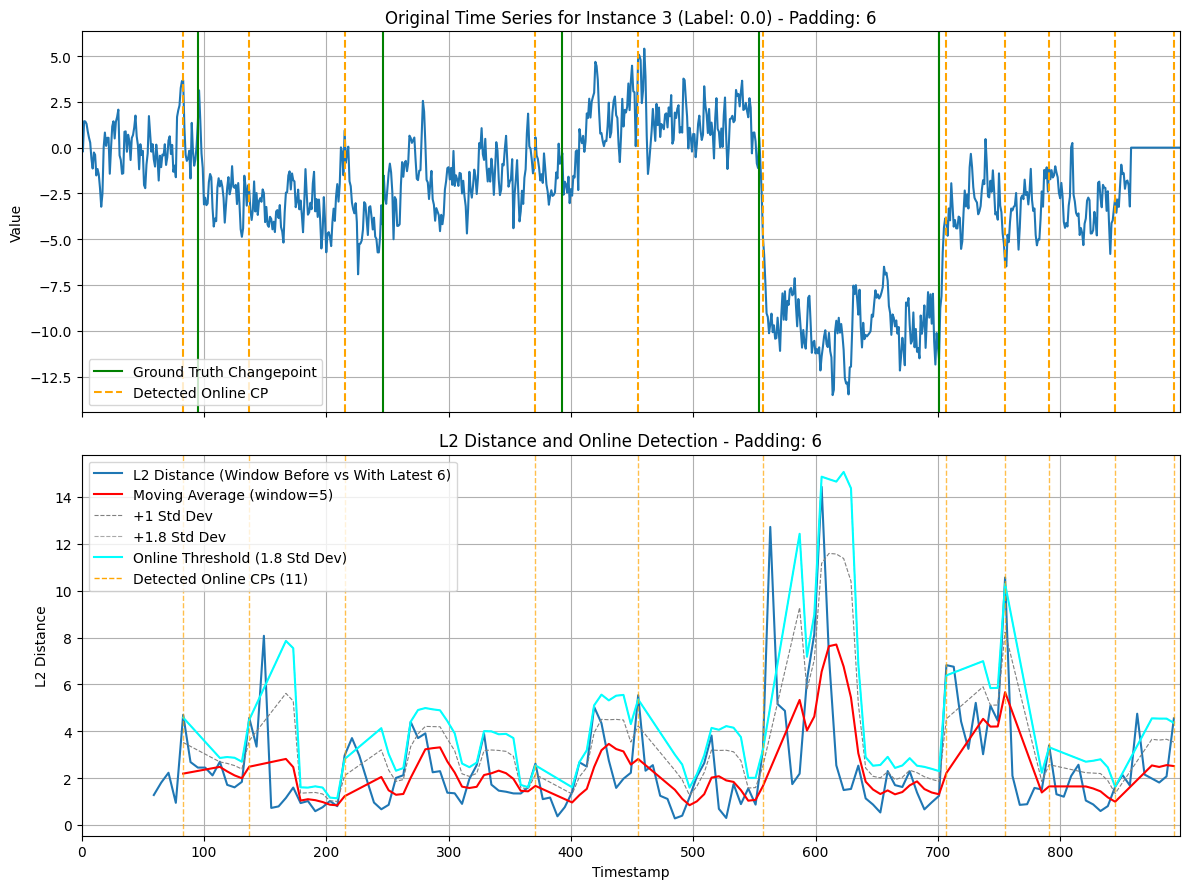

Instance 3 Evaluation (Padding: 6): TP=1, FP=10, FN=4, Precision=0.09, Recall=0.20, F1=0.13
Changepoint detected at timestamp 101 for instance 4
Changepoint detected at timestamp 149 for instance 4
Changepoint detected at timestamp 185 for instance 4
Changepoint detected at timestamp 233 for instance 4
Changepoint detected at timestamp 305 for instance 4
Changepoint detected at timestamp 395 for instance 4
Changepoint detected at timestamp 431 for instance 4
Changepoint detected at timestamp 545 for instance 4
Changepoint detected at timestamp 593 for instance 4
Changepoint detected at timestamp 659 for instance 4
Changepoint detected at timestamp 875 for instance 4


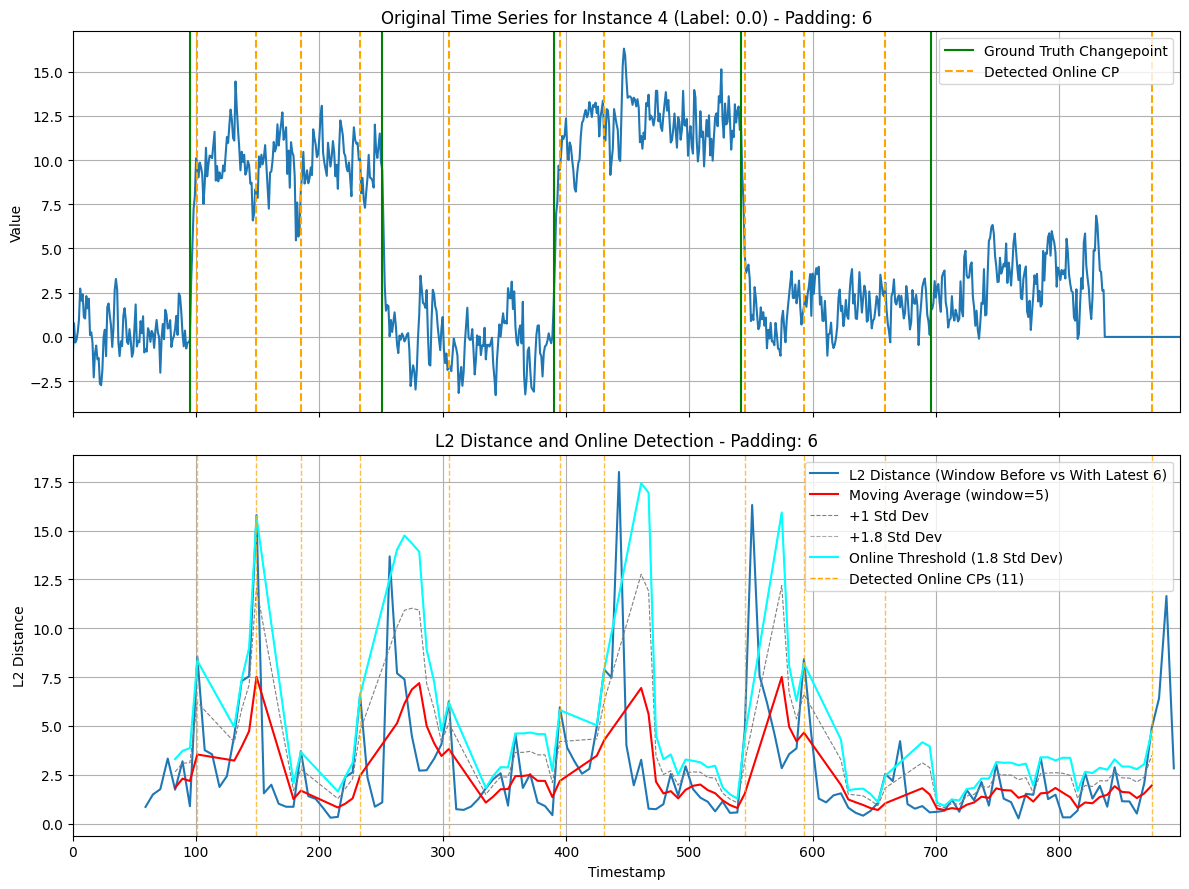

Instance 4 Evaluation (Padding: 6): TP=2, FP=9, FN=3, Precision=0.18, Recall=0.40, F1=0.25
Changepoint detected at timestamp 101 for instance 5
Changepoint detected at timestamp 155 for instance 5
Changepoint detected at timestamp 245 for instance 5
Changepoint detected at timestamp 299 for instance 5
Changepoint detected at timestamp 551 for instance 5
Changepoint detected at timestamp 755 for instance 5
Changepoint detected at timestamp 785 for instance 5
Changepoint detected at timestamp 827 for instance 5


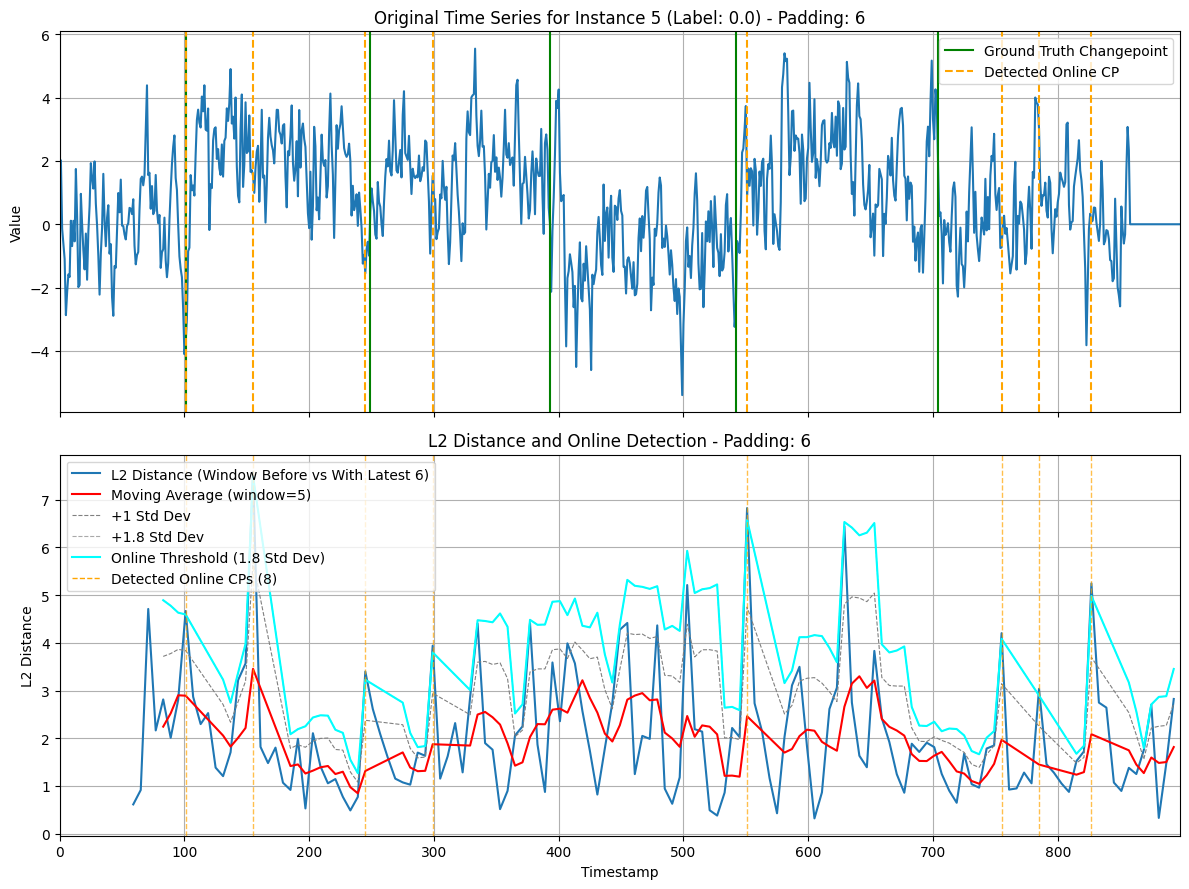

Instance 5 Evaluation (Padding: 6): TP=2, FP=6, FN=3, Precision=0.25, Recall=0.40, F1=0.31

Average Evaluation Metrics for Padding 6:
  Average TP: 1.40
  Average FP: 9.00
  Average FN: 3.60
  Average Precision: 0.14
  Average Recall: 0.28
  Average F1-score: 0.18


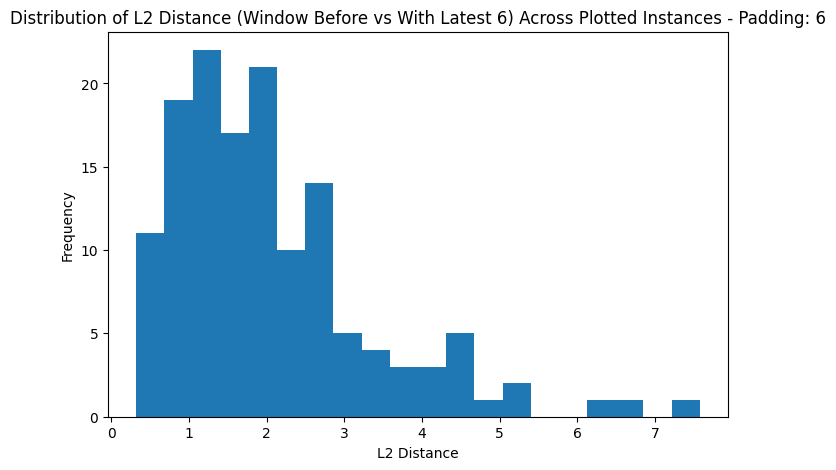


Evaluation Results by Sliding Padding:


{6: {'average_tp': np.float64(1.4),
  'average_fp': np.float64(9.0),
  'average_fn': np.float64(3.6),
  'average_precision': np.float64(0.13787878787878788),
  'average_recall': np.float64(0.27999999999999997),
  'average_f1_score': np.float64(0.18359728506787332)}}

In [58]:
# Assuming 'model' is your trained TS2Vec model,
# 'test_data' is your test data (np.ndarray),
# and 'test_labels' are your test labels (np.ndarray).

# Replace these with your actual variables
# model = your_ts2vec_model
# test_data = your_test_data
# test_labels = your_test_labels
# ground_truth_cps = your_ground_truth_cps # Optional: provide ground truth CPs if available

# Example parameters (adjust as needed)
sliding_length = 1
sliding_padding = 6
num_instances_to_plot = 5
moving_average_window = 5
evaluation_tolerance = 5
matched_filter_kernel_size = 20 # Set to 0 or None to disable matched filter
filter_cosine_similarity = True # Set to False to filter the difference signal (if peak_on_difference)
stddev_threshold_multiplier = 1.8
num_latest_points_to_compare = 6
local_window_size = 48

# Call the componentized analysis function
evaluation_results = run_changepoint_analysis_componentized(
    model=trained_model,
    test_data=test_data_gen,
    test_labels=test_labels_gen,
    sliding_length=sliding_length,
    sliding_padding=sliding_padding,
    num_instances_to_plot=num_instances_to_plot,
    moving_average_window=moving_average_window,
    ground_truth_cps=ground_truth_cps_gen, # Pass ground truth if available
    peak_on_difference=False, # Set to False to plot peaks on similarity
    evaluation_tolerance=evaluation_tolerance,
    stddev_threshold_multiplier=stddev_threshold_multiplier,
    num_latest_points_to_compare = num_latest_points_to_compare,
    local_window_size=local_window_size
)

# Display the evaluation results
print("\nEvaluation Results by Sliding Padding:")
display(evaluation_results)